## Python을 이용한 개인화 추천 시스템(임일 저)

### 1. 주요 추천 알고리즘  

    1) 협업 필터링  
        구매한 제품에 대한 각 소비자의 평가로 패턴이 비슷한 소비자를 한 집단으로 보고 집단별 취향을 활용하는 기술
        취향이 뚜렷하게 부분되는 제품을 추천할 때 더욱 정확하다.
        평가정보를 구할 수 없는 경우 계속적으로 정보를 검색하는 것, 장바구니에 넣는 것을 평가정보 대신에 활용
        (클릭 스트림 분석을 통해 소비자의 취향이나 니즈를 알아낼 수 있음)
        
    2) 내용 기반 필터링  
        제품의 내용을 분석해서 추천하는 기술. 소비하는 제품 중 텍스트 정보가 많은 제품을 분석하여 추천할 때 많이 이용되는 기술
        어떤 소비자가 현재 관심이 있는 것으로 보이는 책이나 뉴스에서 키워드를 추려내고 다른 책이나 뉴스 중에서 비슷한 키워드를 가진
        것들을 찾아내서 추천
        
    3) 지식 기반 필터링  
        도메인 전문가의 도움을 받아서 지식구조를 만들어 활용하는 방법. 예를 들어 체계도를 만들고 이를 바탕으로 관심있는 제품 제시
        
    4) 딥러닝 추천 기술  
        딥러닝의 입력으로 다양한 사용자와 아이템의 특징값을 사용하고, 이를 통해 얻은 출력은 각 아이템에 대한 각 사용자의 예상  
        선호도로 사용하여 아이템을 추천
      
    5) 하이브리드 기술  
    위에서 언급한 기술들을 복수 사용하여 정확도의 향상을 획득하고자 함

In [1]:
import os
os.getcwd()

'C:\\Users\\USER\\Downloads\\데이터'

In [2]:
os.chdir('C:/Users/USER/Downloads/데이터')

### 2. 기본적인 추천 시스템
##### 　2.1 데이터 불러오기

- 고객 데이터

In [3]:
import pandas as pd
u_cols=['user_id','age','sex','occupation','zip_code']
users=pd.read_csv('u.user',sep='|',names=u_cols,encoding='latin-1')
users=users.set_index('user_id')
users.head()

,age,sex,occupation,zip_code
user_id,,,,
1,24,M,technician,85711
2,53,F,other,94043
3,23,M,writer,32067
4,24,M,technician,43537
5,33,F,other,15213


- 영화 데이터

In [4]:
i_cols = ['movie_id', 'title', 'release date', 'video release date', 'IMDB URL', 
          'unknown', 'Action', 'Adventure', 'Animation', 'Children\'s', 'Comedy', 
          'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 
          'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
movies = pd.read_csv('u.item', sep='|', names=i_cols, encoding='latin-1')
movies = movies.set_index('movie_id')
movies.head()

,title,release date,video release date,IMDB URL,unknown,Action,Adventure,Animation,Children's,Comedy,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movie_id,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


- 유저별 평가 데이터

In [5]:
r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv('u.data', sep='\t', names=r_cols, encoding='latin-1') 
ratings = ratings.set_index('user_id')
ratings.head()

,movie_id,rating,timestamp
user_id,,,
196,242,3,881250949
186,302,3,891717742
22,377,1,878887116
244,51,2,880606923
166,346,1,886397596


#### 　2.2 인기제품 방식 추천
    개별 이용자에 대한 정보가 없는 경우나 정확도에 관계없이 가장 간단한 추천을 제공

In [6]:
# 함수 생성 - movie_mean(영화 평점을 영화 id별로 평균을 냄)이라는 데이터를 정렬한 후 함수에 사용자에 의해 주어진 개수의 영화를 필터링 
#             인덱스를 이용해 movie에서 색인 그 후에 색인한 데이터에서 영화제목을 별도로 추출하여 recommendations라는 출력값을 생성
def recom_movie(n_items):
    movie_sort = movie_mean.sort_values(ascending=False)[:n_items]
    recom_movies = movies.loc[movie_sort.index]
    recommendations = recom_movies['title']
    return recommendations

In [7]:
movie_mean = ratings.groupby(['movie_id'])['rating'].mean()

In [8]:
recom_movie(5)

movie_id
814                         Great Day in Harlem, A (1994)
1599                        Someone Else's America (1995)
1201           Marlene Dietrich: Shadow and Light (1996) 
1122                       They Made Me a Criminal (1939)
1653    Entertaining Angels: The Dorothy Day Story (1996)
Name: title, dtype: object

위 출력 값은 영화 id별 평점 평균이 높은 5개의 영화를 출력한 데이터

#### 　2.3 추천 시스템의 정확도 측정
    rmse를 구하고 이를 이용해 구현한 추천 시스템의 성능을 평가(머신러닝처럼 rmse가 낮을수록 좋은 모형임)

- rmse를 구하는 식 scikit-learn을 이용해도 되고 사용자 정의함수로 만들어도 된다. 

In [9]:
from sklearn.metrics import mean_squared_error
import numpy as np

def RMSE(y_pred,y_true):
    return np.sqrt(mean_squared_error(y_pred,y_true))

In [10]:
# def RMSE(y_true, y_pred ):
#    return np.sqrt(np.mean((np.array(y_true) - np.array(y_pred))**2))

In [11]:
rmse=[]
for user in set(ratings.index):
    y_true = ratings.loc[user]['rating']
    y_pred = movie_mean[ratings.loc[user]['movie_id']]
    accuracy = RMSE(y_true,y_pred)
    rmse.append(accuracy)
print(np.mean(rmse))

0.996007224010567


#### 　2.4 사용자 집단별 추천
     사용자를 비슷한 특성의 사람들을 묶은 소집단으로 만든 다음에 각 집단의 평점평균을 바탕으로 추천하는 것
     인구통계학적 특성을 이용하여 각 코호트로 나누고 추천 시스템을 구현

In [12]:
ratings=ratings.reset_index()
movies=movies.reset_index()
movies = movies[['movie_id','title']]

- train test데이터를 층화 추출법을 이용해 분할하여 train과 test에 id별로 몰려있지 않게 조정

In [13]:
from sklearn.model_selection import train_test_split
x=ratings.copy() # 평점데이터 딥카피
y=ratings['user_id'] # 유저id만 별도로 추려서 층화 추출을 진행
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.25,stratify=y)

In [14]:
# 모델별 RMSE를 계산하는 함수
def score(model):
    id_pairs= zip(x_test['user_id'],x_test['movie_id'])
    y_pred= np.array([model(user,movie) for (user,movie) in id_pairs])
    y_true= np.array(x_test['rating'])
    return RMSE(y_true,y_pred)

In [15]:
# 전체 평균으로 예측치를 계산하는 기본 모델
def best_seller(user_id,movie_id):
    try:
        rating= train_mean[movie_id]
    except:
        rating= 3.0
    return rating

In [16]:
train_mean= x_train.groupby(['movie_id'])['rating'].mean()

In [17]:
score(best_seller)

1.0306940478963158

- train 데이터로 Full matrix 구하기( 사용자 수 943개, 영화 1647개의 매트릭스 생성)

In [18]:
rating_matrix = x_train.pivot(index='user_id',columns='movie_id',values='rating')
rating_matrix

movie_id,1,2,3,4,5,6,7,8,9,10,...,1670,1671,1672,1673,1674,1675,1676,1677,1678,1681
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,NaN,NaN,4.0,NaN,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
940,NaN,NaN,NaN,NaN,NaN,NaN,4.0,5.0,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
941,5.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- 성별 코호트를 사용하여 영화 추천 및 rmse 계산

In [19]:
users=users.reset_index()

In [20]:
# Full matrix를 사용자 데이터와 merge
merged_ratings = pd.merge(x_train,users)
users = users.set_index('user_id')

# gender 별 평점평균계산
g_mean = merged_ratings[['movie_id','sex','rating']].groupby(['movie_id','sex'])['rating'].mean()
g_mean 

movie_id  sex
1         F      3.790698
          M      3.911290
2         F      3.428571
          M      3.072289
3         F      2.666667
                   ...   
1675      M      3.000000
1676      M      2.000000
1677      F      3.000000
1678      M      1.000000
1681      M      3.000000
Name: rating, Length: 3047, dtype: float64

In [21]:
g_mean 

movie_id  sex
1         F      3.790698
          M      3.911290
2         F      3.428571
          M      3.072289
3         F      2.666667
                   ...   
1675      M      3.000000
1676      M      2.000000
1677      F      3.000000
1678      M      1.000000
1681      M      3.000000
Name: rating, Length: 3047, dtype: float64

- 성별 영화 평점평균을 구해주는 함수

In [22]:
def cf_gender(user_id, movie_id):
    if movie_id in rating_matrix:                     # 주어진 영화 id가 성별 영화점수가 있으면 그것을 쓰고 없으면 3.0을 쓴다.
        gender= users.loc[user_id]['sex']
        if gender in g_mean[movie_id]:
            gender_rating= g_mean[movie_id][gender]
        else:                                         # 해당 영화 id가 매트릭스에는 있는데 평가한 성별이 없으면 평점을 3.0을 쓴다. 
            gender_rating= 3.0
    else:
        gender_rating= 3.0
    return gender_rating

In [23]:
score(cf_gender)

1.0385466458925277

- 성별 코호트로 성별 평균 기반 추천 시스템을 만들면 rmse가 오히려 커져서 성능이 더 안좋아 진다.

***

#### 　3.1 협업 필터링 추천 시스템
        2장에서 처럼 인구 통계학적 기준으로 추천하는 것이 아닌 취향을 기준으로 나누는 것이 협업필터링(Collaborative Filtering)이다.  
        기본적인 아이디어는 index로 유저, columns는 items를 놓고 각 유저의 상관정도(상관계수,유사도)를 측정한다.  
        기본적으로 상관계수는 0.7보다 큰 경우 강한 상관관계를 갖는다고 보고 있으므로, 취향이 비슷한 유저로 본다.
        해당 유저 A가 취향이 비슷한 유저가 유저 A가 구매하지 않은 item에 대해 평점 평균을 내고 그 중 제일 높은 아이템을 추천한다.
        CF는 사용자들의 평가를 기본으로 사용자 간 유사도를 구하는 것이 핵심이다. 그리고 상관계수와 코사인 유사도를 기반으로 측정한다.

#### 　3.2 기본 CF 알고리즘

In [24]:
rating_matrix= x_train.pivot(index='user_id',columns='movie_id',values='rating')

In [25]:
from sklearn.metrics.pairwise import cosine_similarity
matrix_dummy = rating_matrix.copy().fillna(0)
user_similarity = cosine_similarity(matrix_dummy,matrix_dummy)
user_similarity=pd.DataFrame(user_similarity,index=rating_matrix.index,columns=rating_matrix.index)

In [26]:
# 주어진 영화의 (movie_id)의 가중평균 rating을 계산하는 함수
# 가중치는 주어진 사용자와 다른 사용자 간의 유사도(user_similarity)
def CF_simple(user_id,movie_id):
    if movie_id in rating_matrix:
        sim_scores = user_similarity[user_id].copy()
        movie_ratings = rating_matrix[movie_id].copy()
        none_rating_idx = movie_ratings[movie_ratings.isnull()].index
        movie_ratings = movie_ratings.dropna()
        sim_scores = sim_scores.drop(none_rating_idx)
        mean_rating = np.dot(sim_scores,movie_ratings) / sim_scores.sum()
        # 주어진 영화에 대해 평가한 각 사용자에 대해 평점을 유사도로 가중평균한 예측치를 구한다.
        # np.dot : 각 자리 수끼리 곱하여 전부 더한다. 즉, 각 자리수의 곱의 합 / 전체의 합
    else:
        mean_rating = 3.0
    return mean_rating

In [27]:
score(CF_simple)

1.0242833751858988

#### 　3.3 이웃을 고려한 CF
            기본 CF 알고리즘을 개선할 수 있는 한 가지 방법은 유사도가 높은 사람만을 이웃으로 선정해서 이웃의 크기를 줄이는 것임
            이웃의 크기는 K Nearst Neighbors(KNN) 방법이고 또 다른 하나는 유사도의 기준(상관계수 0.8 이상)을 정해 놓고, 이 기준을  
            충족시키는 사용자를 이웃으로 정하는 Thresholding이다. 
            Thresholding 방법이 KNN보다 정확하기는 하지만 정해진 기준을 넘는 사용자가 없어서 추천을 하지 못하는 경우가 많기 때문에 
            KNN이 무난하게 많이 쓰인다.

In [28]:
# 모델별 RMSE를 계산하는 함수 
def score(model, neighbor_size=0):
    id_pairs = zip(x_test['user_id'], x_test['movie_id'])
    y_pred = np.array([model(user, movie, neighbor_size) for (user, movie) in id_pairs])
    y_true = np.array(x_test['rating'])
    return RMSE(y_true, y_pred)

In [29]:
def cf_knn(user_id, movie_id, neighbor_size=0):
    if movie_id in rating_matrix:
        # 현재 사용자와 다른 사용자 간의 similarity 가져오기
        sim_scores = user_similarity[user_id].copy()
        # 현재 영화에 대한 모든 사용자의 rating값 가져오기
        movie_ratings = rating_matrix[movie_id].copy()
        # 현재 영화를 평가하지 않은 사용자의 index 가져오기
        none_rating_idx = movie_ratings[movie_ratings.isnull()].index
        # 현재 영화를 평가하지 않은 사용자의 rating (null) 제거
        movie_ratings = movie_ratings.drop(none_rating_idx)
        # 현재 영화를 평가하지 않은 사용자의 similarity값 제거
        sim_scores = sim_scores.drop(none_rating_idx)
##### (2) Neighbor size가 지정되지 않은 경우        
        if neighbor_size == 0:          
            # 현재 영화를 평가한 모든 사용자의 가중평균값 구하기
            mean_rating = np.dot(sim_scores, movie_ratings) / sim_scores.sum()
##### (3) Neighbor size가 지정된 경우
        else:                       
            # 해당 영화를 평가한 사용자가 최소 2명이 되는 경우에만 계산
            if len(sim_scores) > 1: 
                # 지정된 neighbor size 값과 해당 영화를 평가한 총사용자 수 중 작은 것으로 결정
                neighbor_size = min(neighbor_size, len(sim_scores))
                # array로 바꾸기 (argsort를 사용하기 위함)
                sim_scores = np.array(sim_scores)
                movie_ratings = np.array(movie_ratings)
                # 유사도를 순서대로 정렬
                user_idx = np.argsort(sim_scores)
                # 유사도를 neighbor size만큼 받기
                sim_scores = sim_scores[user_idx][-neighbor_size:]
                # 영화 rating을 neighbor size만큼 받기
                movie_ratings = movie_ratings[user_idx][-neighbor_size:]
                # 최종 예측값 계산 
                mean_rating = np.dot(sim_scores, movie_ratings) / sim_scores.sum()
            else:
                mean_rating = 3.0
    else:
        mean_rating = 3.0
    return mean_rating

In [30]:
score(cf_knn,neighbor_size=30)

1.0157328475590361

- 이웃을 고려하지 않은 simple_CF보다 RMSE가 약간 개선되었음을 볼 수 있다.

####  　3.4 최적의 이웃 크기 결정
        최적의 이웃 크기는 이웃의 크기가 증가하면서 추천의 정확도가 증가하다가 어느 시점 이후에는 감소하는 형태를 보인다.
        즉, 추천의 정확도를 최대로 하는 최적의 이웃 크기가 존재하는 것이 보통이다.
        머신러닝에서 최적의 파라미터 조합을 찾는 것처럼 처음에는 이웃의 크기를 크게 변화시켜보고 그 후 세밀하게 변환시켜 결과를 본다.

In [31]:
# 이웃 크기를 10부터 60까지 설정
rating_matrix = x_train.pivot_table(index='user_id',columns='movie_id',values='rating')
mtrix_dummy= rating_matrix.copy().fillna(0)
user_similarity = cosine_similarity(matrix_dummy,matrix_dummy)
user_similarity = pd.DataFrame(user_similarity,index=rating_matrix.index,columns=rating_matrix.index)
n_size=[]
for neighbor_size in np.arange(10,61,10):
    n_size.append('Neighbor size= %d : RMSE = %.4f' % (neighbor_size, score(cf_knn,neighbor_size)))
n_size

['Neighbor size= 10 : RMSE = 1.0316',
 'Neighbor size= 20 : RMSE = 1.0181',
 'Neighbor size= 30 : RMSE = 1.0157',
 'Neighbor size= 40 : RMSE = 1.0153',
 'Neighbor size= 50 : RMSE = 1.0160',
 'Neighbor size= 60 : RMSE = 1.0169']

In [32]:
# rmse가 제일 낮은 
n_size=[]
for neighbor_size in np.arange(35,46):
    n_size.append('Neighbor size= %d : RMSE = %.4f' % (neighbor_size, score(cf_knn,neighbor_size)))
n_size

['Neighbor size= 35 : RMSE = 1.0153',
 'Neighbor size= 36 : RMSE = 1.0152',
 'Neighbor size= 37 : RMSE = 1.0152',
 'Neighbor size= 38 : RMSE = 1.0155',
 'Neighbor size= 39 : RMSE = 1.0155',
 'Neighbor size= 40 : RMSE = 1.0153',
 'Neighbor size= 41 : RMSE = 1.0152',
 'Neighbor size= 42 : RMSE = 1.0153',
 'Neighbor size= 43 : RMSE = 1.0154',
 'Neighbor size= 44 : RMSE = 1.0153',
 'Neighbor size= 45 : RMSE = 1.0154']

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

In [34]:
rmse=np.array([float(i.split(':')[1].split('=')[1]) for i in n_size])

In [35]:
n_neighbors=np.arange(35,46)

<AxesSubplot:>

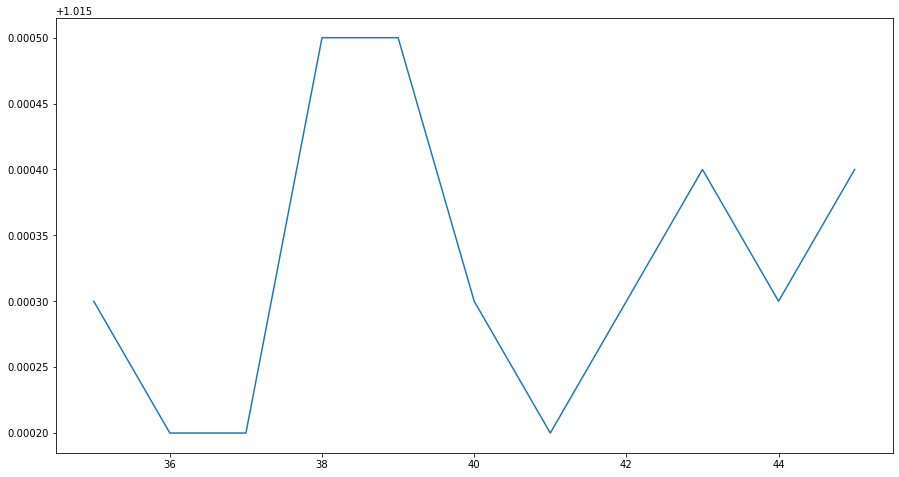

In [36]:
plt.figure(figsize=(15,8))
sns.lineplot(x=n_neighbors,y=rmse)